#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)

In [1]:
import random
import torch
import numpy as np

def fix_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [2]:
fix_seed(555)

### Import required modules

In [3]:
from model.vrae import VRAE

from model.utils import *
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange
import tqdm

import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler


### Input parameters

In [4]:
dload = './saved_model' #download directory

### utils.load_data

In [5]:
def load_gen_data(file_name, scale_type = 'Standard', cols_to_remove = None):
    """
    folder: folder where data is located
    """
    
    # define path(must be in pkl file)
    data_loc = f'./data/netis/{file_name}.pkl'    
    
    # get data
    with open(data_loc, 'rb') as f:
        df = pickle.load(f)
    
    # if needed remove columns that is not necessary
    if cols_to_remove != None:
        df = df_total.drop(cols_to_remove, axis=1)
    
    df = df.dropna()
    
    # TRAIN TEST SPLIT
    # TRAIN
    TRAIN_DF = df.query('Time < 20211103184400 or Time > 20211106084400 and label==0')
    
    # TEST(GET ONLY 정상)
    TEST_DF = df.query('Time >= 20211103184400 and Time <= 20211106084400 and label==0')

    TOTAL_DF = df.to_numpy()
    
    # REMOVE TIME & LABEL
    TRAIN_DF = TRAIN_DF.iloc[:,1:-1]
    cols = TRAIN_DF.columns
    TRAIN_DF = TRAIN_DF.to_numpy()
    TEST_DF = TEST_DF.iloc[:,1:-1].to_numpy()
    
    if scale_type == 'MinMax':
        scaler = MinMaxScaler()
    elif scale_type == 'Standard':
        scaler = StandardScaler()
    else:
        pass
    
    TRAIN_SCALED = scaler.fit(TRAIN_DF).transform(TRAIN_DF)
    TEST_SCALED = scaler.transform(TEST_DF)
    
    return TOTAL_DF, TRAIN_DF, TEST_DF, TRAIN_SCALED, TEST_SCALED, cols, scaler

### Hyper parameters

### Load data and preprocess
- `file_name` : pkl file_name
- `cols_to_remove` : generation 수행하지 않을 column 제거

In [6]:
# params
file_name = 'netis'

# load data
TOTAL_DF, TRAIN_DF, TEST_DF, TRAIN_SCALED, TEST_SCALED, cols, scaler = load_gen_data(file_name)

# shape
print(TOTAL_DF.shape)
print(TRAIN_SCALED.shape)
print(TEST_SCALED.shape)

(26002, 94)
(22363, 92)
(3627, 92)


In [9]:
class GenerationDataset(Dataset):
    def __init__(self, data, window):
        self.data = torch.Tensor(data)
        self.window = window
 
    def __len__(self):
        return len(self.data) // self.window # -1
    
    def __getitem__(self, index):
#         x = self.data[index*self.window:index*(self.window+1)]
        x = self.data[index*self.window:(index+1)*(self.window)]
        return x

In [10]:
window = 100

In [11]:
train_dataset = GenerationDataset(TRAIN_SCALED, window)
train_dataset

In [12]:
test_dataset = GenerationDataset(TEST_SCALED, window)
test_dataset

In [13]:
train_dataset[0].shape

torch.Size([100, 92])

**Fetch `sequence_length` from dataset**

In [14]:
sequence_length = train_dataset[0].shape[0]
sequence_length

100

**Fetch `number_of_features` from dataset**

This config corresponds to number of input features

In [15]:
number_of_features = train_dataset[0].shape[1]
number_of_features

92

### Parameters

In [16]:
n_epochs = 1000
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 1
learning_rate = 0.0002
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [17]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Fit the model onto dataset

In [18]:
loss_arr = vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
# vrae.fit(dataset, save = True)

Epoch: 0
Batch 30, loss = 6855.2100, recon_loss = 6855.1846, kl_loss = 0.0252
Batch 60, loss = 1188.4844, recon_loss = 1188.3091, kl_loss = 0.1754
Batch 90, loss = 316.5652, recon_loss = 315.4057, kl_loss = 1.1595
Batch 120, loss = 413.5472, recon_loss = 412.3996, kl_loss = 1.1476
Batch 150, loss = 6007.3052, recon_loss = 6007.2036, kl_loss = 0.1016
Batch 180, loss = 7153.2642, recon_loss = 7152.8135, kl_loss = 0.4506
Batch 210, loss = 7340.1143, recon_loss = 7340.0249, kl_loss = 0.0893
Average loss: 6676.5800
Epoch: 1
Batch 30, loss = 6820.3652, recon_loss = 6819.2285, kl_loss = 1.1368
Batch 60, loss = 1181.7334, recon_loss = 1179.9885, kl_loss = 1.7449
Batch 90, loss = 267.5953, recon_loss = 265.8129, kl_loss = 1.7824
Batch 120, loss = 398.7572, recon_loss = 398.1660, kl_loss = 0.5912
Batch 150, loss = 6088.2271, recon_loss = 6086.9175, kl_loss = 1.3095
Batch 180, loss = 7244.5718, recon_loss = 7242.5273, kl_loss = 2.0445
Batch 210, loss = 7337.3154, recon_loss = 7336.8760, kl_loss =

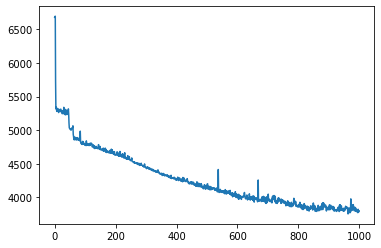

In [19]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)

### Save the model to be fetched later

In [20]:
vrae.save('vrae.pth')

# To load a presaved model, execute:
# vrae.load('vrae.pth')

In [21]:
vrae.is_fitted

True

### Transform the input timeseries to encoded latent vectors

In [22]:
z_run = vrae.transform(test_dataset)
z_run

array([[-1.99363911e+00,  3.93842757e-01, -5.89321852e-01,
         2.19673634e+00, -1.39903438e+00,  1.28040707e+00,
        -7.28604555e-01,  2.15234280e+00,  1.45998263e+00,
        -7.03450799e-01, -2.14699149e+00,  8.33608568e-01,
        -1.32847297e+00,  1.68153572e+00, -6.01502836e-01,
         2.02788591e-01, -5.00740945e-01,  1.42827630e-01,
        -1.28968549e+00,  1.65135324e+00],
       [-1.70540094e+00,  3.41354191e-01,  1.63596079e-01,
         2.87861013e+00, -7.75635898e-01,  1.57950568e+00,
        -9.89969552e-01,  1.74462521e+00,  1.27011704e+00,
        -1.34317589e+00, -2.28757811e+00,  3.25513005e-01,
        -1.12953961e+00,  1.44364214e+00, -6.76260591e-01,
        -2.77088761e-01, -4.99913424e-01,  1.83525980e-01,
        -1.74868965e+00,  1.11356795e+00],
       [-1.79842114e+00,  8.40272605e-02, -1.44356295e-01,
         2.90861988e+00, -1.61729872e+00,  1.47798514e+00,
        -1.42279637e+00,  2.00542092e+00,  1.41630483e+00,
        -1.21596932e+00, -2.7

In [23]:
z_run.shape

(36, 20)

In [24]:
from einops import rearrange
import torch.nn as nn

In [43]:
def concat_recon(recon_output):
    
    w,b,f = recon_output.shape
    tmp = rearrange(recon_output, 'w b f -> b w f')
    output = tmp.reshape(w*b,f)

    return output

def inverse_minmax(x):
    
    inv_x = scaler.inverse_transform(x)
    
    return inv_x

def eval_recon(recon, real, undo = True):
    criterion = nn.MSELoss()
    
    if undo == True:
        # undo minmax scaling
        recon = inverse_minmax(recon)
    
    r = recon.shape[0]
    real = real[:r,:]
    
    # get shape
    print(recon.shape)
    print(real.shape)

    # compute loss
    loss = criterion(torch.tensor(recon), torch.tensor(real))
    
    return loss

def get_diff(recon, real, undo = True):
    if undo == True:
        # undo minmax scaling
        recon = inverse_minmax(recon)
    
    r = recon.shape[0]
    real = real[:r,:]
    
    return recon, real, np.abs(recon-real)

## Reconstruct

### Train

In [84]:
# train reconstruct
train_recon = vrae.reconstruct(train_dataset)
print(train_recon.shape)

(100, 223, 92)


In [45]:
train_recon = concat_recon(train_recon)
train_recon.shape

(22300, 92)

In [46]:
eval_recon(train_recon, TRAIN_DF)

(22300, 92)
(22300, 92)


tensor(3.6674e+13, dtype=torch.float64)

In [47]:
eval_recon(train_recon, TRAIN_SCALED, False)

(22300, 92)
(22300, 92)


tensor(0.4121, dtype=torch.float64)

### Visualize Train Difference

In [59]:
train_recon, train_real, train_diff  = get_diff(train_recon, TRAIN_SCALED, False)
train_diff.shape

(22300, 92)

In [83]:
train_recon = pd.DataFrame(train_recon, columns= cols)
train_real = pd.DataFrame(train_real, columns= cols)
train_diff = pd.DataFrame(train_diff, columns= cols)

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

plt.rcParams["figure.figsize"] = (20,5)

for i in cols:
    print(f'Saving plot {i}')
    plt.plot(train_diff[i])
    plt.title(f'{i}')
    plt.savefig(f'./plots/train/{i}.png')
    plt.clf() # Clear the current figure

# plt.plot(train_diff[cols[random.randrange(92)]])
# plt.title(f'{cols[random.randrange(92)]}')

Saving plot Device2Port1_AVG_INBPS
Saving plot Device2Port1_AVG_OUTBPS
Saving plot Device2Port4_AVG_INBPS
Saving plot Device2Port4_AVG_OUTBPS
Saving plot Device2Port6_AVG_INBPS
Saving plot Device2Port6_AVG_OUTBPS
Saving plot Device2Port8_AVG_INBPS
Saving plot Device2Port8_AVG_OUTBPS
Saving plot Device2Port10_AVG_INBPS
Saving plot Device2Port10_AVG_OUTBPS
Saving plot Device2Port12_AVG_INBPS
Saving plot Device2Port12_AVG_OUTBPS
Saving plot Device2Port14_AVG_INBPS
Saving plot Device2Port14_AVG_OUTBPS
Saving plot Device2Port19_AVG_INBPS
Saving plot Device2Port19_AVG_OUTBPS
Saving plot Device2Port21_AVG_INBPS
Saving plot Device2Port21_AVG_OUTBPS
Saving plot Device2Port22_AVG_INBPS
Saving plot Device2Port22_AVG_OUTBPS
Saving plot Device2Port23_AVG_INBPS
Saving plot Device2Port23_AVG_OUTBPS
Saving plot Device2Port24_AVG_INBPS
Saving plot Device2Port24_AVG_OUTBPS
Saving plot Device2Port4097_AVG_INBPS
Saving plot Device2Port4097_AVG_OUTBPS
Saving plot Device15Port1_AVG_INBPS
Saving plot Device1

<Figure size 1440x360 with 0 Axes>

### Test

In [30]:
# test reconstruct
test_recon = vrae.reconstruct(test_dataset)
print(test_recon.shape)
test_recon

(100, 36, 92)


array([[[ 1.69066697e-01, -1.11968070e-01,  4.39207889e-02, ...,
          1.65839338e+00, -1.17160058e+00, -7.79552817e-01],
        [ 4.10982341e-01,  2.91083574e-01,  4.25384976e-02, ...,
          2.31703019e+00, -1.40817869e+00, -1.14214873e+00],
        [ 1.16652921e-02, -1.81149781e-01,  5.27637713e-02, ...,
          2.01204729e+00, -1.53570426e+00, -9.29854989e-01],
        ...,
        [-1.16910540e-01, -1.82009339e-02, -6.86170384e-02, ...,
          8.39057565e-01, -1.30339086e+00,  3.08250815e-01],
        [-1.36026919e-01, -8.68294835e-02, -1.91996396e-02, ...,
          7.63758123e-01, -1.10627866e+00,  8.30737829e-01],
        [ 4.18466404e-02, -1.21069729e-01, -9.17559266e-02, ...,
          8.50077093e-01, -1.09996188e+00,  1.03429425e+00]],

       [[-6.72452673e-02, -3.39912057e-01, -2.86027901e-02, ...,
          1.72469819e+00, -1.04504752e+00, -6.58043146e-01],
        [-1.46012455e-01, -3.96044791e-01, -3.59739214e-02, ...,
          2.49410939e+00, -1.42154765e

In [31]:
test_recon = concat_recon(test_recon)
test_recon.shape

(3600, 92)

In [32]:
eval_recon(test_recon, TEST_DF)

(3600, 92)
(3600, 92)


tensor(3.1764e+12, dtype=torch.float64)

In [33]:
eval_recon(test_recon, TEST_SCALED, False)

(3600, 92)
(3600, 92)


tensor(0.8574, dtype=torch.float64)

In [80]:
test_recon, test_real, test_diff  = get_diff(test_recon, TEST_SCALED, False)
test_diff.shape

(3600, 92)

In [81]:
test_recon = pd.DataFrame(test_recon, columns= cols)
test_real = pd.DataFrame(test_real, columns= cols)
test_diff = pd.DataFrame(test_diff, columns= cols)

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

plt.rcParams["figure.figsize"] = (20,5)

for i in cols:
    print(f'Saving plot {i}')
    plt.plot(test_diff[i])
    plt.title(f'{i}')
    plt.savefig(f'./plots/test/{i}.png')
    plt.clf() # Clear the current figure


# plt.plot(train_diff[cols[random.randrange(92)]])
# plt.title(f'{cols[random.randrange(92)]}')

Saving plot Device2Port1_AVG_INBPS
Saving plot Device2Port1_AVG_OUTBPS
Saving plot Device2Port4_AVG_INBPS
Saving plot Device2Port4_AVG_OUTBPS
Saving plot Device2Port6_AVG_INBPS
Saving plot Device2Port6_AVG_OUTBPS
Saving plot Device2Port8_AVG_INBPS
Saving plot Device2Port8_AVG_OUTBPS
Saving plot Device2Port10_AVG_INBPS
Saving plot Device2Port10_AVG_OUTBPS
Saving plot Device2Port12_AVG_INBPS
Saving plot Device2Port12_AVG_OUTBPS
Saving plot Device2Port14_AVG_INBPS
Saving plot Device2Port14_AVG_OUTBPS
Saving plot Device2Port19_AVG_INBPS
Saving plot Device2Port19_AVG_OUTBPS
Saving plot Device2Port21_AVG_INBPS
Saving plot Device2Port21_AVG_OUTBPS
Saving plot Device2Port22_AVG_INBPS
Saving plot Device2Port22_AVG_OUTBPS
Saving plot Device2Port23_AVG_INBPS
Saving plot Device2Port23_AVG_OUTBPS
Saving plot Device2Port24_AVG_INBPS
Saving plot Device2Port24_AVG_OUTBPS
Saving plot Device2Port4097_AVG_INBPS
Saving plot Device2Port4097_AVG_OUTBPS
Saving plot Device15Port1_AVG_INBPS
Saving plot Device1

<Figure size 1440x360 with 0 Axes>